In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import h2o
from sklearn.metrics import roc_curve, auc, precision_recall_curve


In [85]:
data_dir = '../data/'
output_dir = '../output/'
date = "20250420"
featureset = 'featureset.csv'

In [86]:
figure_colors = [
    '#4269D0', # orange
    '#FF8AB7', # blue
    '#6CC5B0', # red
    '#374e55' # gray
]

In [ ]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_451"; Java(TM) SE Runtime Environment (build 1.8.0_451-b10); Java HotSpot(TM) 64-Bit Server VM (build 25.451-b10, mixed mode)
  Starting server from /Users/fujimoto/Desktop/MedICU/research-dic-prediction-2025/scripts/myenv/lib/python3.13/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/mw/7366jqyd24db0gsndhcd1cl00000gn/T/tmpfinux65g
  JVM stdout: /var/folders/mw/7366jqyd24db0gsndhcd1cl00000gn/T/tmpfinux65g/h2o_fujimoto_started_from_python.out
  JVM stderr: /var/folders/mw/7366jqyd24db0gsndhcd1cl00000gn/T/tmpfinux65g/h2o_fujimoto_started_from_python.err
  Server is running at http://127.0.0.1:54343
Connecting to H2O server at http://127.0.0.1:54343 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Tokyo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_fujimoto_wjnrix
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.541 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [ ]:
# Retrieve the ID and model name from the full path
def extract_modelname(input_string: str):
    last_slash_index = input_string.rfind('/')
    after_last_slash = input_string[last_slash_index + 1:]
    first_underscore_index = after_last_slash.find('_')
    id = after_last_slash
    name = after_last_slash[:first_underscore_index]
    return id,name

def acquire_models(path: str) -> dict:
    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith("best_model:"):
                best_model_path = line.strip().split(": ")[1]
                best_model_id,best_model_name= extract_modelname(best_model_path)
            elif line.startswith("second_model:"):
                second_model_path = line.strip().split(": ")[1]
                second_model_id,second_model_name= extract_modelname(second_model_path)
            elif line.startswith("third_model:"):
                third_model_path = line.strip().split(": ")[1]
                third_model_id,third_model_name= extract_modelname(third_model_path)
            
    models = {"best":{"id":best_model_id,"name":best_model_name,"path":best_model_path},
              "second":{"id":second_model_id,"name":second_model_name,"path":second_model_path},
              "third":{"id":third_model_id,"name":third_model_name,"path":third_model_path},
             }
    return models

model1 = acquire_models(f"{date}/model_path_best_latest_model1.txt")
model1_minimum = acquire_models(f"{date}/model_path_best_latest_model1_minimum.txt")
model1_compact = acquire_models(f"{date}/model_path_best_latest_model1_compact.txt")

In [98]:
best_model_m1 = h2o.load_model(model1["best"]["path"])
best_model_m1_minimum = h2o.load_model(model1_minimum["best"]["path"])
best_model_m1_compact = h2o.load_model(model1_compact["best"]["path"])

In [100]:
def process_df(path_train: str, path_test: str, vars: list, label: str) -> None:
    train = h2o.import_file(os.path.join(data_dir, date, path_train))
    train = train[vars]
    test = h2o.import_file(os.path.join(data_dir, date, path_test))
    test = test[vars]

    y = label
    train[y] = train[y].asfactor()
    test[y] = test[y].asfactor()

    return train, test

In [ ]:
df = pd.read_csv(os.path.join(data_dir,featureset))

#retrieve the features from the featureset for each model
minimum_model_features = df[df['minimum model'] == 1]['Feature'].tolist()
compact_model_features = df[df['compact model'] == 1]['Feature'].tolist()
full_model_features = df[df['full model'] == 1]['Feature'].tolist()

vars_full = full_model_features+['y']
vars_minimum = minimum_model_features+['y']
vars_compact = compact_model_features+['y']

In [102]:
full_train, full_test = process_df(f'{date}_train_df_model1.csv', f"{date}_test_df_model1.csv", vars_full,'y')
minimum_train, minimum_test = process_df(f'{date}_train_df_model1.csv', f"{date}_test_df_model1.csv", vars_minimum,'y')
compact_train, compact_test = process_df(f'{date}_train_df_model1.csv', f"{date}_test_df_model1.csv", vars_compact,'y')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


### Calculate AUROC, AUPRC, SHAP using models

In [103]:
perf_m1= best_model_m1.model_performance(full_test)
perf_m1_minimum = best_model_m1_minimum.model_performance(minimum_test)
perf_m1_compact = best_model_m1_compact.model_performance(compact_test)

In [104]:
# Calculate the AUROC
auroc_full = perf_m1.auc()
auroc_minimum = perf_m1_minimum.auc()
auroc_compact = perf_m1_compact.auc()
print(f"model1 full Test AUROC: {auroc_full}")
print(f"model1 minimum Test AUROC: {auroc_minimum}")
print(f"model1 compact Test AUROC: {auroc_compact}")

model1 full Test AUROC: 0.9151704600849088
model1 minimum Test AUROC: 0.8510257961303589
model1 compact Test AUROC: 0.8838376452444894


In [ ]:
best_predict_m1 = best_model_m1.predict(full_test)
full_test['predict_all_model'] = best_predict_m1['p1']
best_predict_df = full_test.as_data_frame()

In [ ]:
best_predict_m1_minimum = best_model_m1_minimum.predict(minimum_test)
minimum_test['predict_all_model'] = best_predict_m1_minimum['p1']
best_predict_df_minimum = minimum_test.as_data_frame()

In [ ]:
best_predict_m1_compact = best_model_m1_compact.predict(compact_test)
compact_test['predict_all_model'] = best_predict_m1_compact['p1']
best_predict_df_compact = compact_test.as_data_frame()

### ROC Plot


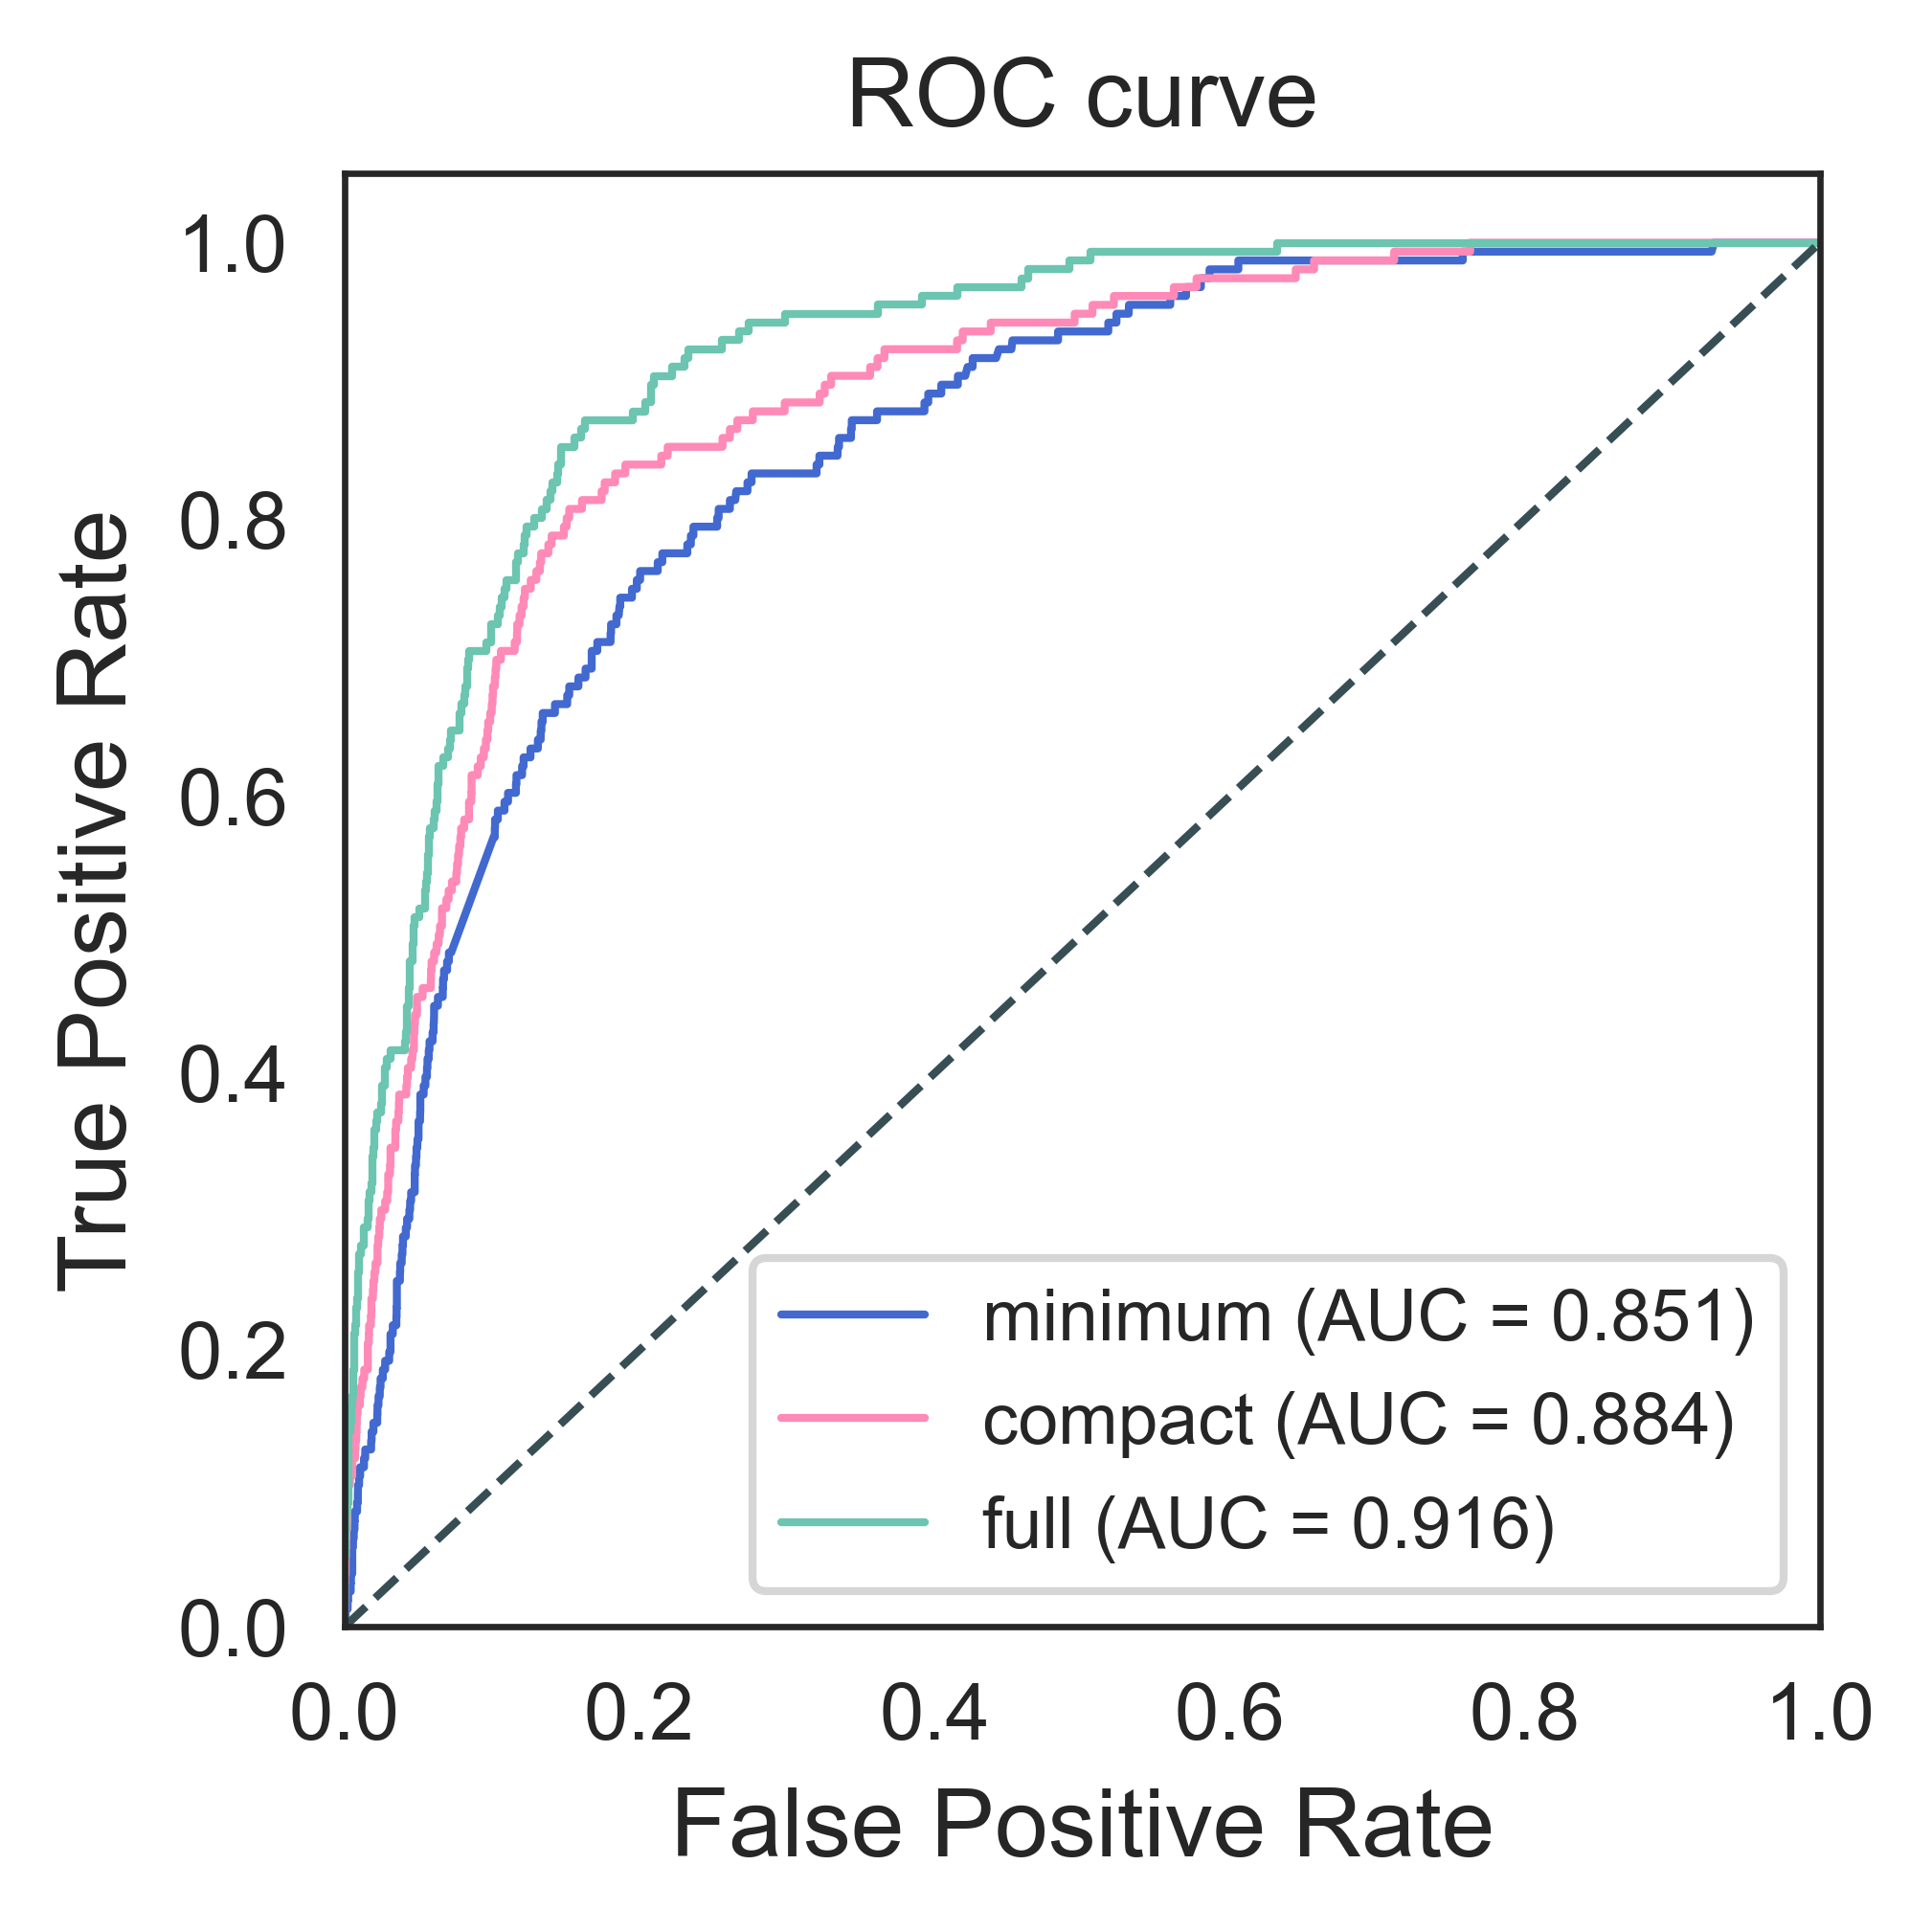

In [68]:
# Compute ROC curve and ROC area
fpr1, tpr1, _ = roc_curve(best_predict_df['y'], best_predict_df['predict_all_model'])
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(best_predict_df_minimum['y'], best_predict_df_minimum['predict_all_model'])
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(best_predict_df_compact['y'], best_predict_df_compact['predict_all_model'])
roc_auc3 = auc(fpr3, tpr3)

width_in_inches = 88 / 25.4
height_in_inches = 88 / 25.4
dpi = 600

# Plotting the ROC curve
plt.rcParams['font.family'] = 'Arial'

plt.figure(figsize=(width_in_inches,height_in_inches),dpi=dpi)
sns.set_style("white")
plt.plot(fpr2, tpr2, color=figure_colors[0], lw=1, label=f'minimum (AUC = {roc_auc2:.3f})')
plt.plot(fpr3, tpr3, color=figure_colors[1], lw=1, label=f'compact (AUC = {roc_auc3:.3f})')
plt.plot(fpr1, tpr1, color=figure_colors[2], lw=1, label=f'full (AUC = {roc_auc1:.3f})')

plt.plot([0, 1], [0, 1], color=figure_colors[3], lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve', fontsize=12)
plt.legend(loc="lower right", fontsize=9)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f'figures/model1/{date}_ROC_curve_3best.tiff'))
plt.show()

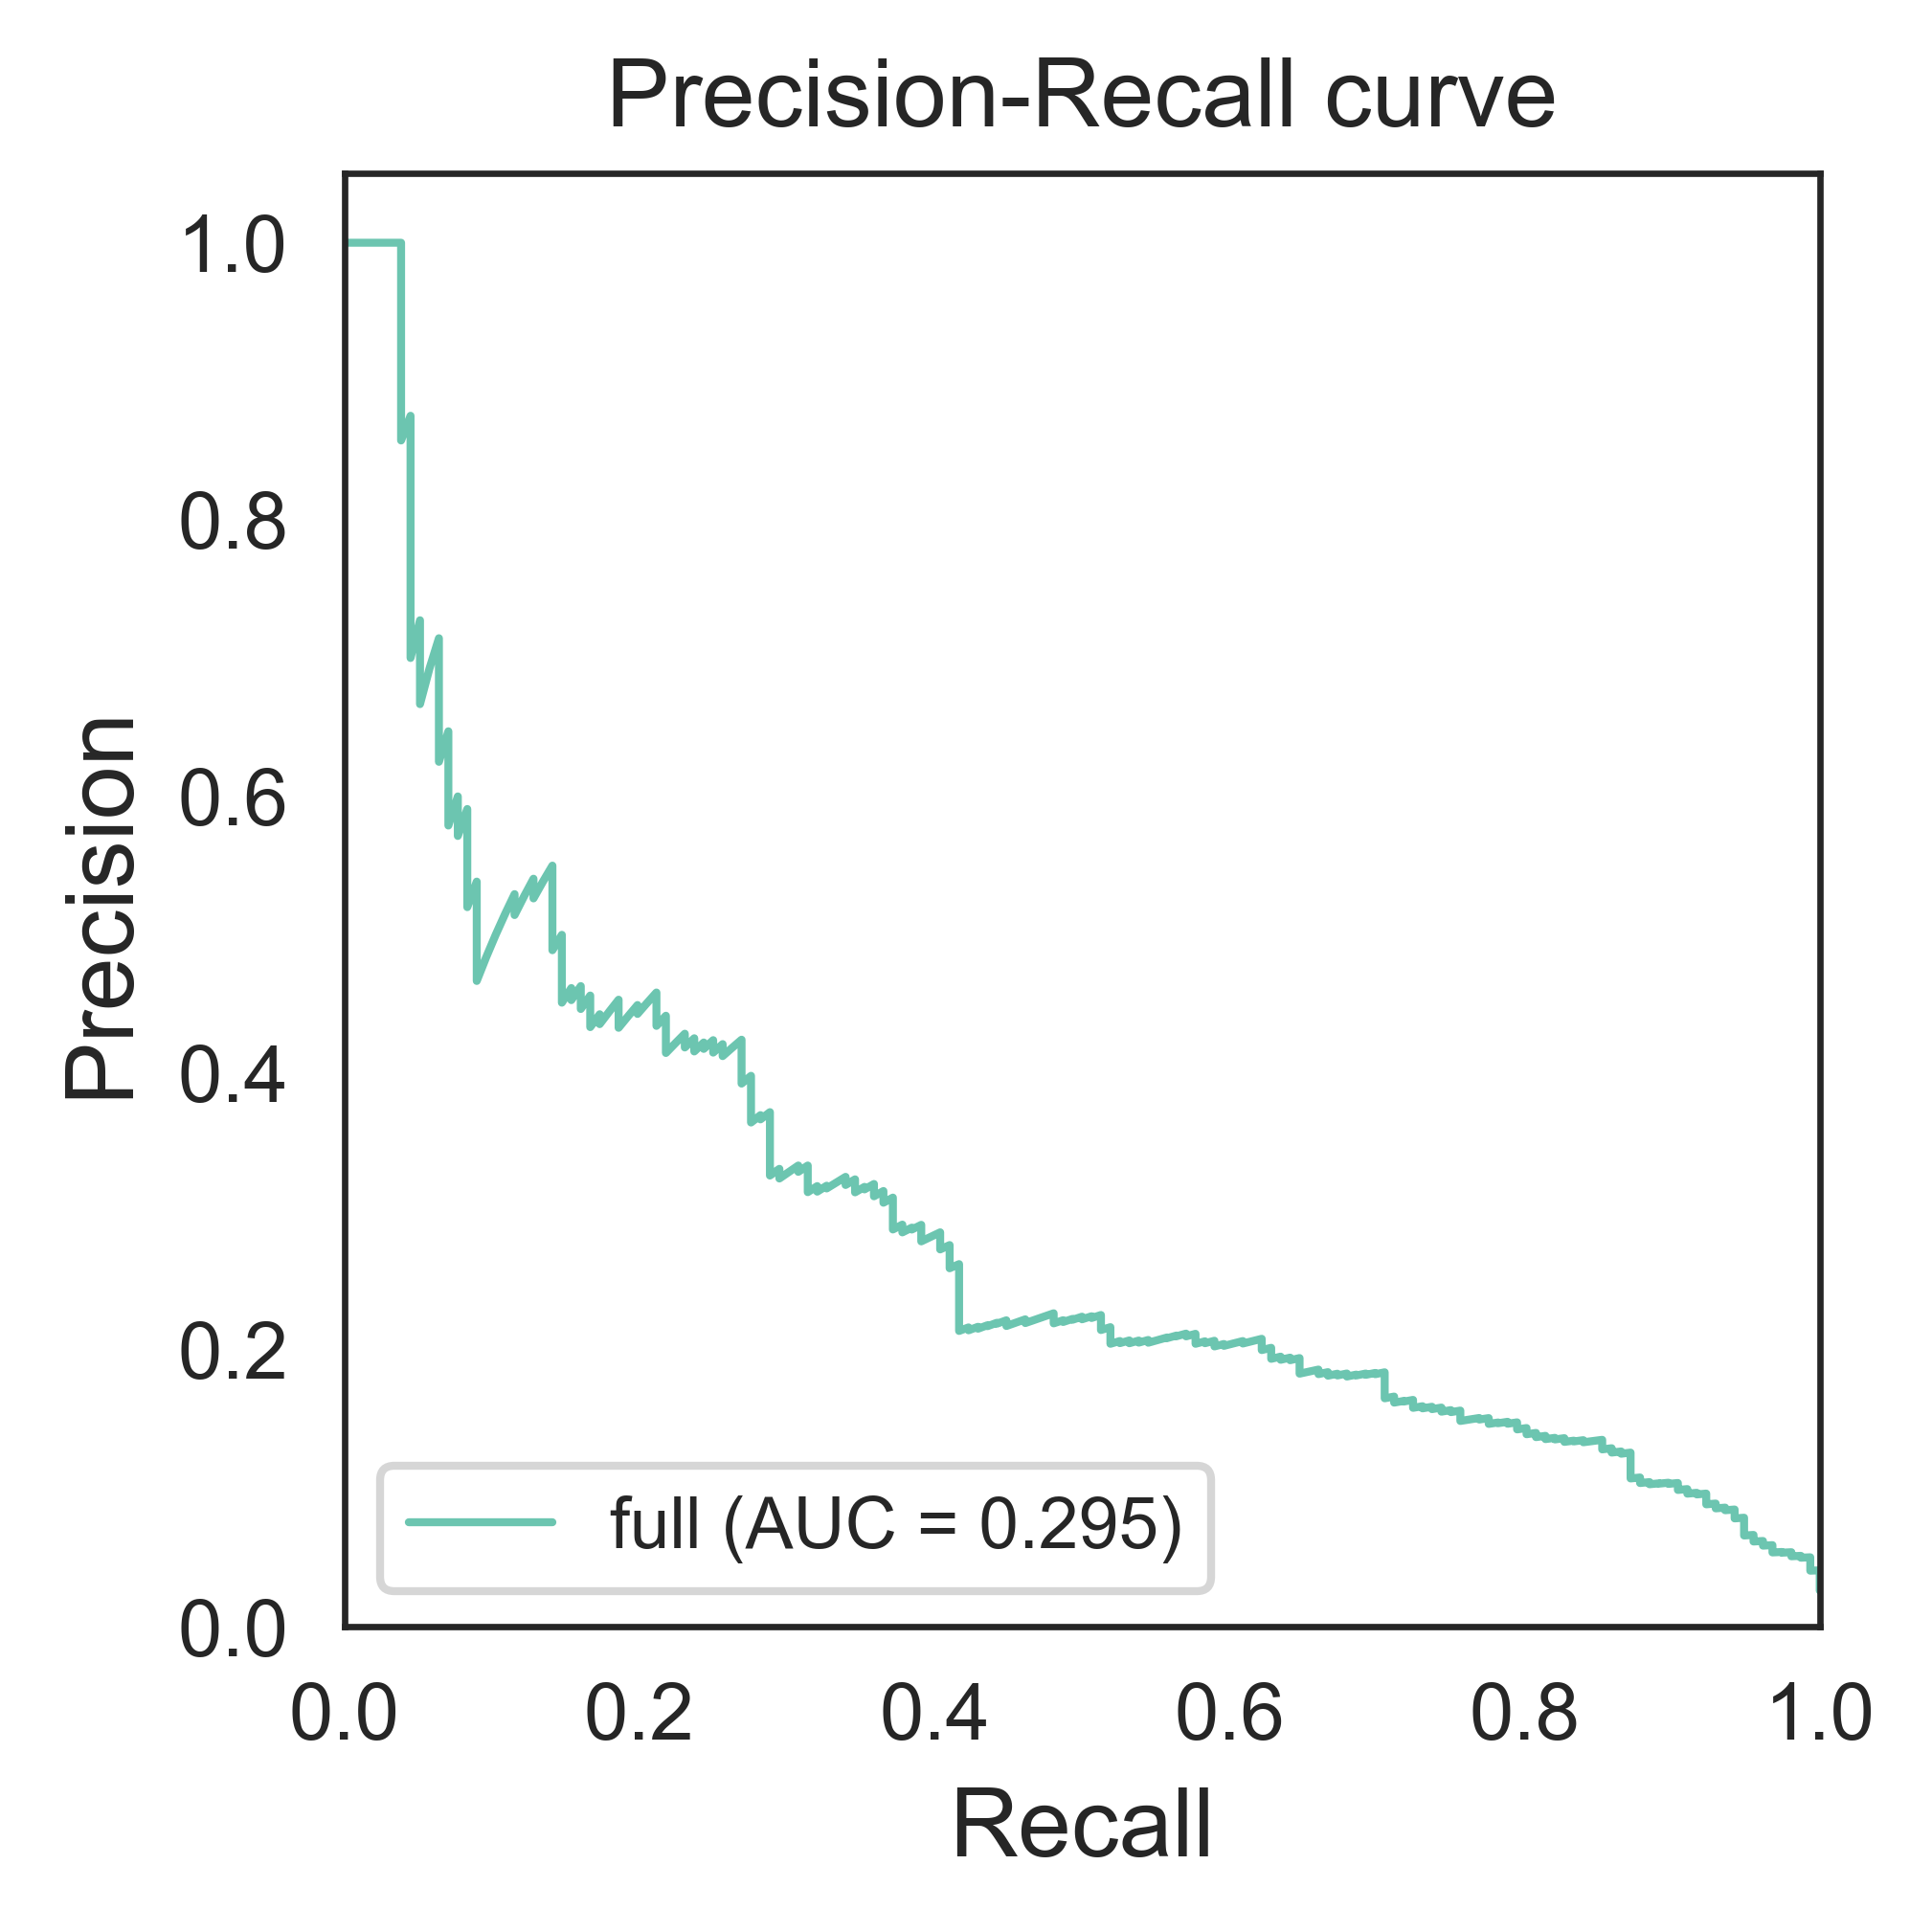

In [74]:
# Compute Precision-Recall curve and area for "full" model
precision1, recall1, _ = precision_recall_curve(best_predict_df['y'], best_predict_df['predict_all_model'])
pr_auc1 = auc(recall1, precision1)

# Define figure size and DPI
width_in_inches = 88 / 25.4
height_in_inches = 88 / 25.4
dpi = 600

# Plotting the Precision-Recall curve for the full model
plt.rcParams['font.family'] = 'Arial'

plt.figure(figsize=(width_in_inches, height_in_inches), dpi=dpi)
sns.set_style("white")

# Plot the Precision-Recall curve for full model
plt.plot(recall1, precision1, color=figure_colors[2], lw=1, label=f'full (AUC = {pr_auc1:.3f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall curve', fontsize=12)
plt.legend(loc="lower left", fontsize=9)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# Adjust layout to avoid cutting off labels
plt.tight_layout()

# Save the plot
plt.savefig(os.path.join(output_dir, f'figures/model1/{date}_PR_curve_full.tiff'))
plt.show()

### SHAP socre plot

In [107]:
model_explanation_beta = h2o.get_model(model1["best"]["id"])

In [ ]:
# Check the data types of each column
print(full_test.types)

{'Female': 'int', 'Height': 'real', 'Age': 'int', 'Time window index': 'int', 'pH': 'real', 'Base excess': 'real', 'Lactate': 'real', 'Glucose': 'int', 'WBC': 'real', 'Hemoglobin': 'real', 'Platelet': 'int', 'Creatinine': 'real', 'Total bilirubin': 'real', 'CRP': 'real', 'Albumin': 'real', 'APTT': 'real', 'PT-INR': 'real', 'D-dimer': 'real', 'Fibrinogen': 'real', 'FDP': 'real', 'Nervous system infection': 'int', 'Cardiovascular infection': 'int', 'Respiratory infection': 'int', 'Abdominal infection': 'int', 'Urinary tract infection': 'int', 'Soft tissue infection': 'int', 'Other infection': 'int', 'Charlson comorbidity index': 'int', 'PaO2/FiO2 ratio': 'real', 'BT (median)': 'real', 'BT (90 percentile)': 'real', 'HR (10 percentile)': 'real', 'HR (median)': 'real', 'HR (90 percentile)': 'real', 'HR (sd)': 'real', 'RR (10 percentile)': 'real', 'RR (median)': 'real', 'RR (90 percentile)': 'real', 'RR (sd)': 'real', 'SBP (10 percentile)': 'real', 'SBP (median)': 'real', 'SBP (90 percentile

In [ ]:
# enum type variables removed for SHAP calculation
full_test = full_test.drop(['y'])

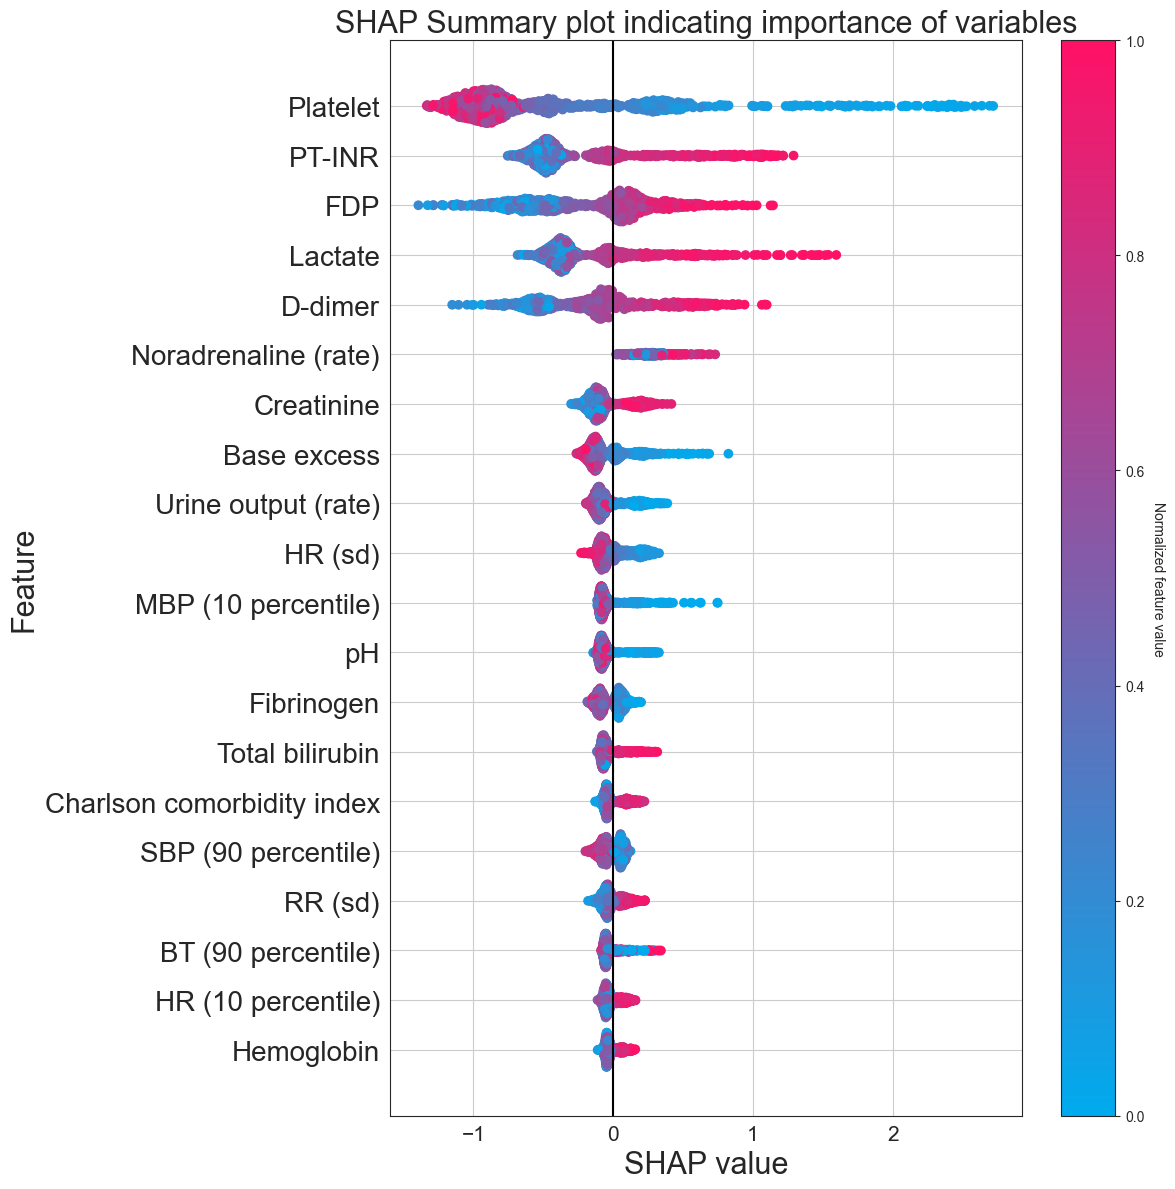

In [ ]:
shap_plot = model_explanation_beta.shap_summary_plot(full_test,top_n_features=20,figsize=(12, 12))
plt.title("SHAP Summary plot indicating importance of variables", fontsize=22)
plt.xlabel(plt.gca().get_xlabel(), fontsize=22)
plt.ylabel(plt.gca().get_ylabel(), fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
plt.tight_layout()

plt.savefig(os.path.join(output_dir, f'figures/model1/{date}_SHAP_full.tiff'))
plt.savefig(os.path.join(output_dir, f'figures/model1/{date}_SHAP_full.tiff'), format='tiff')
plt.show()